In [1]:
import numpy as np
import numpy.random as rd
import matplotlib
import matplotlib.pyplot as plt
import numba as nb

In [2]:
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['axes.linewidth'] = 1.5
plt.rcParams["figure.dpi"] = 200
# sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=10)

In [3]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler("color",["#8ecae6","#219ebc","#023047","#ffb703","#fb8500"])
Mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#8ecae6","#219ebc","#023047","#ffb703","#fb8500"])

### Lattice

In [4]:
def create_lattice(N):
    a1 = np.array([3,np.sqrt(3)])*0.5
    a2 = np.array([3,-np.sqrt(3)])*0.5
    X = np.zeros((N,N))
    Y = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            X[i,j] = (i*a1[0]+j*a2[0])
            Y[i,j] = (i*a1[1]+j*a2[1])
    return X,Y

def spins_generator(N):
    """
    Generates a 2D grid of spins, the X and Y direction are enumerated in the tex file.
    """
    spins = rd.choice(np.array([-1,1]),size = (N,N))
    return spins

In [5]:
x,y = create_lattice(20)

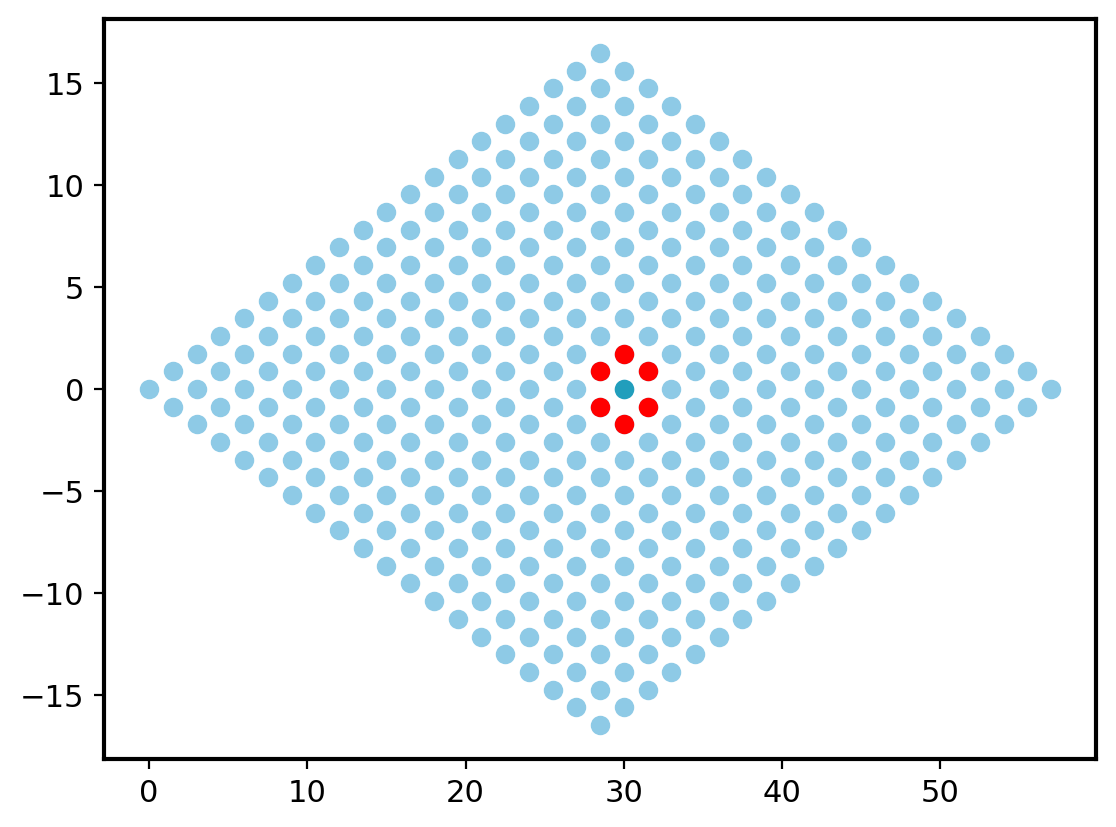

In [6]:
n = 10
a1 = np.array([3,np.sqrt(3)])*0.5
a2 = np.array([3,-np.sqrt(3)])*0.5
x0 = n*a1[0]+n*a2[0]
y0 = n*a1[1]+n*a2[1]

plt.scatter(x,y)
plt.scatter(x0,y0)
plt.scatter(x0+a1[0],y0+a1[1],color="r")
plt.scatter(x0-a1[0],y0-a1[1],color="r")
plt.scatter(x0+a2[0],y0+a2[1],color="r")
plt.scatter(x0-a2[0],y0-a2[1],color="r")
plt.scatter(x0+a2[0]-a1[0],y0+a2[1]-a1[1],color="r")
plt.scatter(x0-a2[0]+a1[0],y0-a2[1]+a1[1],color="r")

# Monte Carlo

## Generate initial grid.
## Function to calculate the initial energy of this config

In [7]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
            E+= 0.25*J*init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
            E+= 0.25*J*init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
    return E

In [8]:
@nb.njit
def MC3_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    E  = np.zeros(Nsteps,dtype=nb.float64)
    E2  = np.zeros(Nsteps,dtype=nb.float64)
        
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            
            E0 += dE
            init[X,Y] *= -1
        E[k]  = E0
        E2[k] = E0*E0
        
    return E,E2

In [9]:
steps = 100_000

init = spins_generator(16)
E16,a = MC3_step(steps,2,init,0,1)

init = spins_generator(32)
E32,a = MC3_step(steps,2,init,0,1)

init = spins_generator(64)
E64,a = MC3_step(steps,2,init,0,1)

init = spins_generator(128)
E128,a = MC3_step(steps,2,init,0,1)

(-1.0, 0.0)

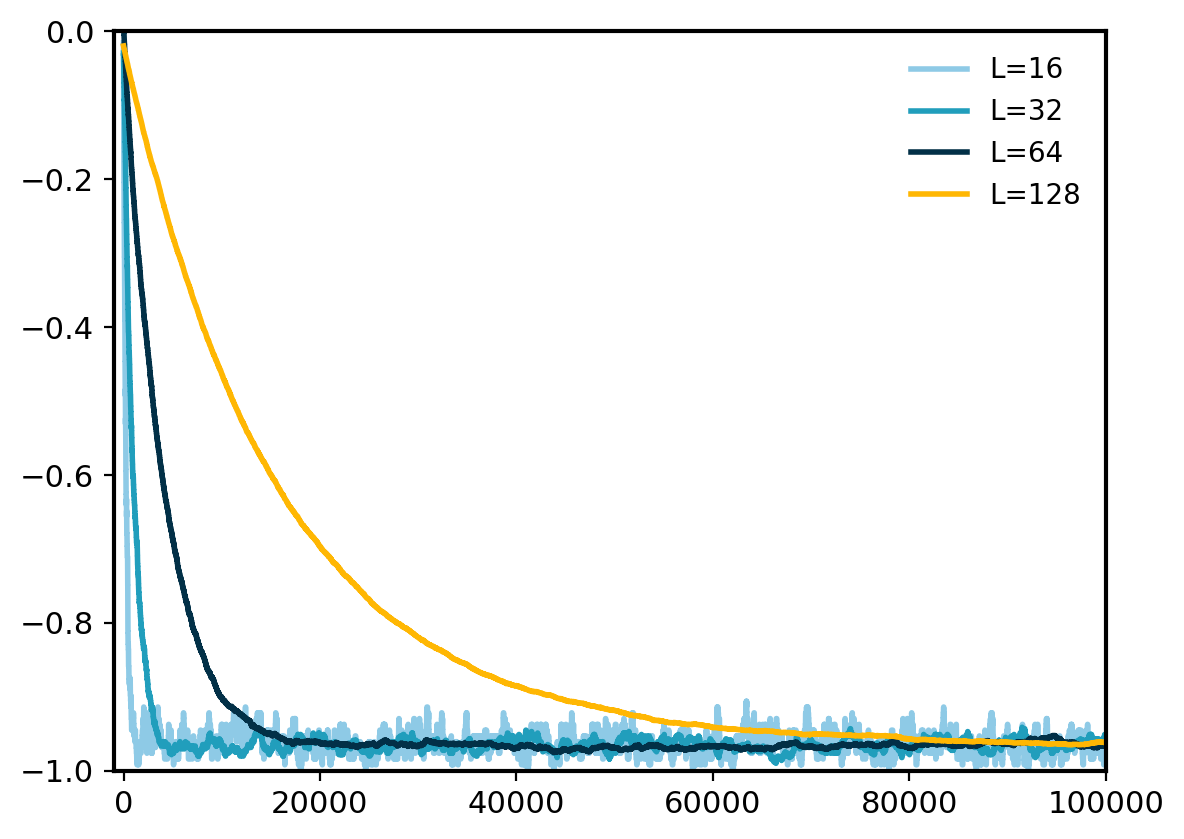

In [10]:
plt.plot(E16/(16*16),label="L=16")
plt.plot(E32/(32*32),label="L=32")
plt.plot(E64/(64*64),label="L=64")
plt.plot(E128/(128*128),label="L=128")
plt.legend(frameon=False)
plt.xlim(-1000,steps)
plt.ylim(-1,0)

## Testing the Code for the Free Limit

In [14]:
def mean_energy_zero(beta,B):
    return -1*B*np.tanh(B*beta)

def heat_capacity_zero(beta,B):
    return beta*beta*B*B/(np.cosh(B*beta))**2

In [15]:
betas = np.linspace(0,2,16)
Ener16 = np.zeros(len(betas))
Heat_Capacity = np.zeros(len(betas))
steps = 200000

for i,b in enumerate(betas):
    init = spins_generator(1)
    l = len(init)
    E,E2 = MC3_step(steps,b,init,0,1)
    Ener16[i] = np.average(E[:])/(l*l)
    Heat_Capacity[i] = b*b*(np.average(E2[:])/(l*l) - Ener16[i]*Ener16[i]*(l*l))

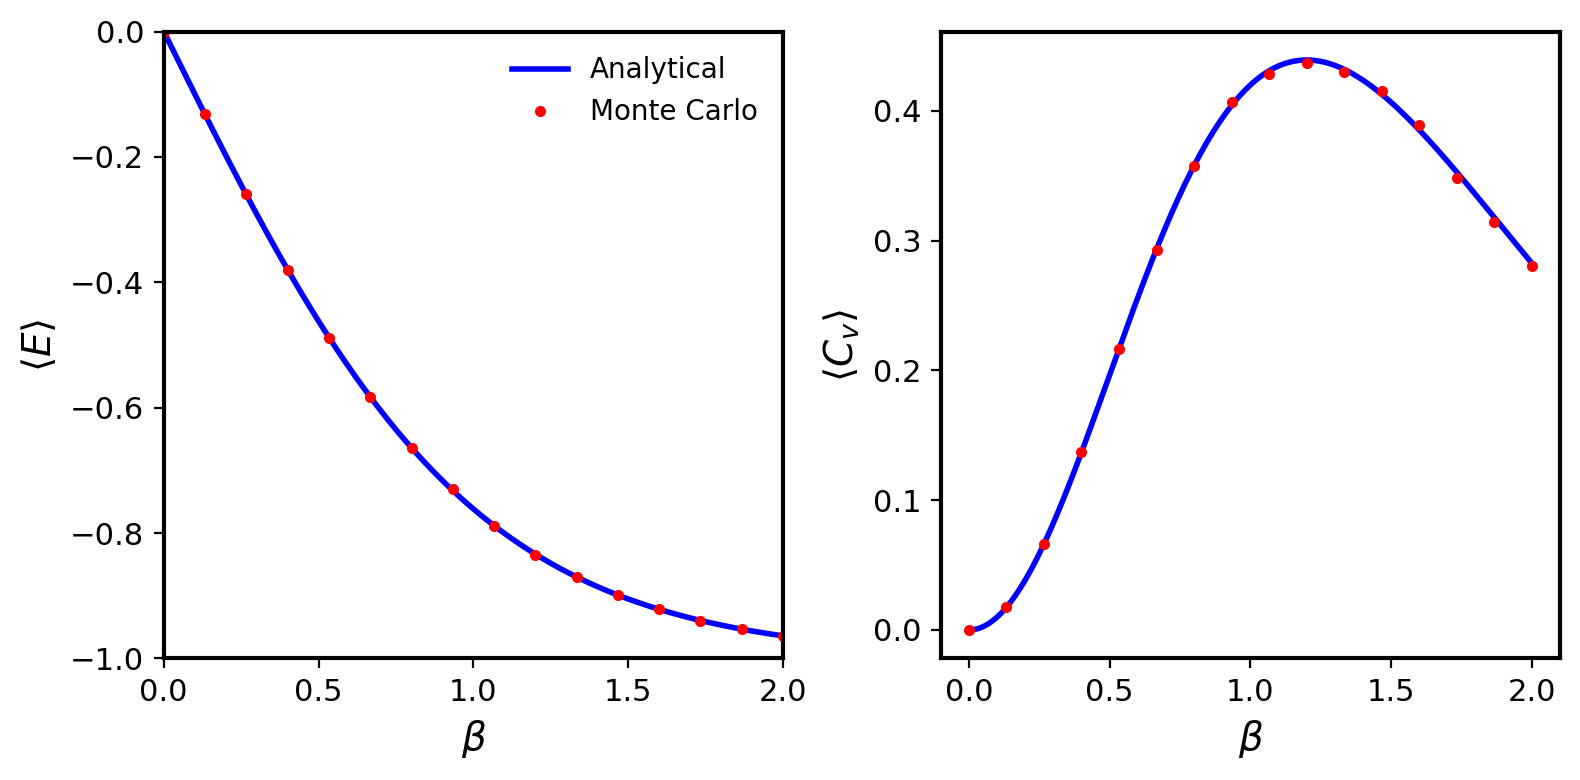

In [16]:
betas2 = np.linspace(0,2,256)

fig,axs = plt.subplots(ncols=2,figsize=(8,4))

axs[0].plot(betas2,mean_energy_zero(betas2,1),"b",label="Analytical")
axs[0].plot(betas,Ener16,"r.",label="Monte Carlo")

axs[1].plot(betas2,heat_capacity_zero(betas2,1),"b",label="Analytical")
axs[1].plot(betas,Heat_Capacity,"r.",label="Monte Carlo")


axs[0].set_xlim(0,2)
axs[0].set_ylim(-1,0)
axs[0].set_xlabel(r"$\beta$")
axs[0].set_ylabel(r"$\langle E \rangle $")

axs[1].set_xlabel(r"$\beta$")
axs[1].set_ylabel(r"$\langle C_v \rangle $")
axs[0].legend(frameon=False)
plt.tight_layout(w_pad=0.5)

### Checking Neel State for Square Lattice

In [17]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
            E+= 0.25*J*init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
            #E+= 0.25*J*init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
    return E

@nb.njit
def MC1_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N   = len(init)
    #array to store the energies:
    E   = np.zeros(Nsteps,dtype=nb.float64)
    E2  = np.zeros(Nsteps,dtype=nb.float64)
    Mag = np.zeros(Nsteps,dtype=nb.float64)
    
    M = np.sum(init)
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        #v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        if rd.random() < np.exp(-beta*dE):
            E0 += dE
            M -= 2*init[X,Y]
            init[X,Y] *= -1
            
        Mag[k] = M
        E[k]  = E0
        E2[k] = E0*E0
        
    return E,E2,Mag,init

In [18]:
init = spins_generator(16)
E,E2,Mag,init = MC1_step(100000,8.0,init,2.0,0.0)

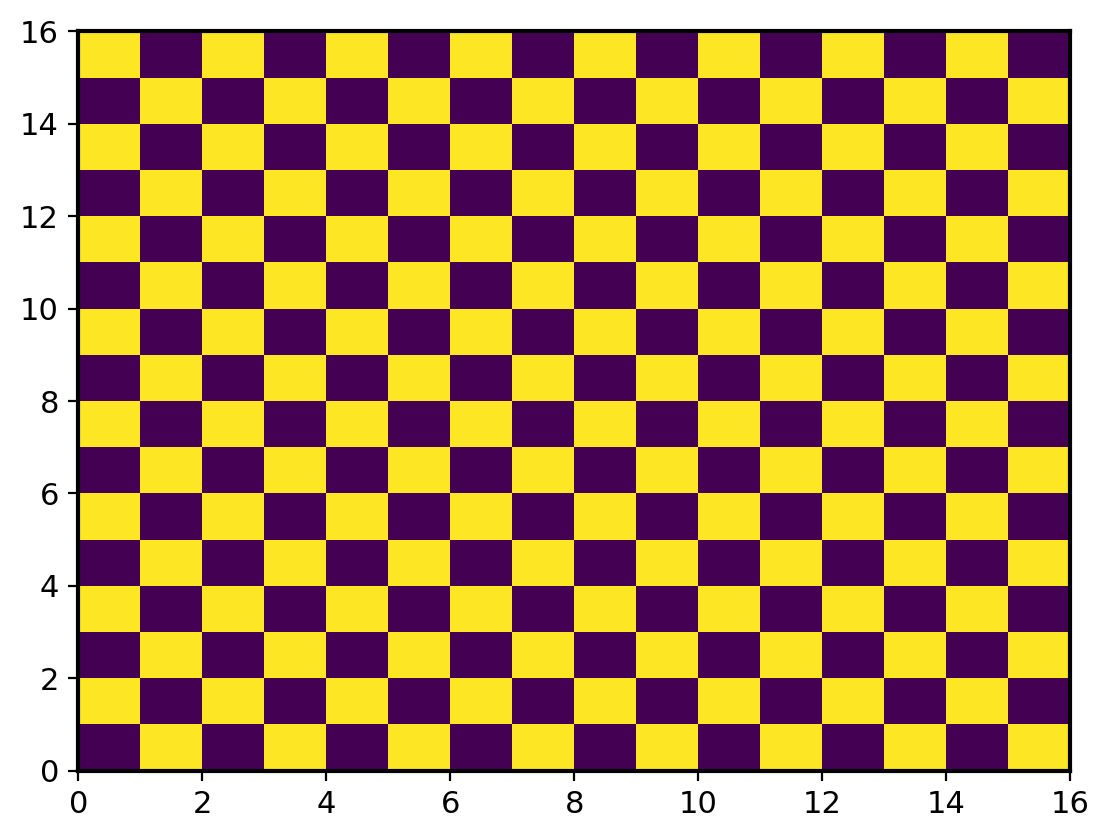

In [19]:
x,y = create_lattice(10)
plt.pcolormesh(init)

# Visualization in the Hexagonal

In [20]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
            E+= 0.25*J*init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
            E+= 0.25*J*init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
    return E

In [21]:
@nb.njit
def MC1_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N   = len(init)
    #array to store the energies:
    E   = np.zeros(Nsteps,dtype=nb.float64)
    E2  = np.zeros(Nsteps,dtype=nb.float64)
    Mag = np.zeros(Nsteps,dtype=nb.float64)
    
    M = np.sum(init)
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            E0 += dE
            M -= 2*init[X,Y]
            init[X,Y] *= -1
            
        Mag[k] = M/(N*N)
        E[k]  = E0/(N*N)
        E2[k] = E0*E0/(N*N)
        
    return E,E2,Mag,init

In [22]:
init = spins_generator(32)
E,E2,Mag,init = MC1_step(10000,8.0,init,2.0,0.0)

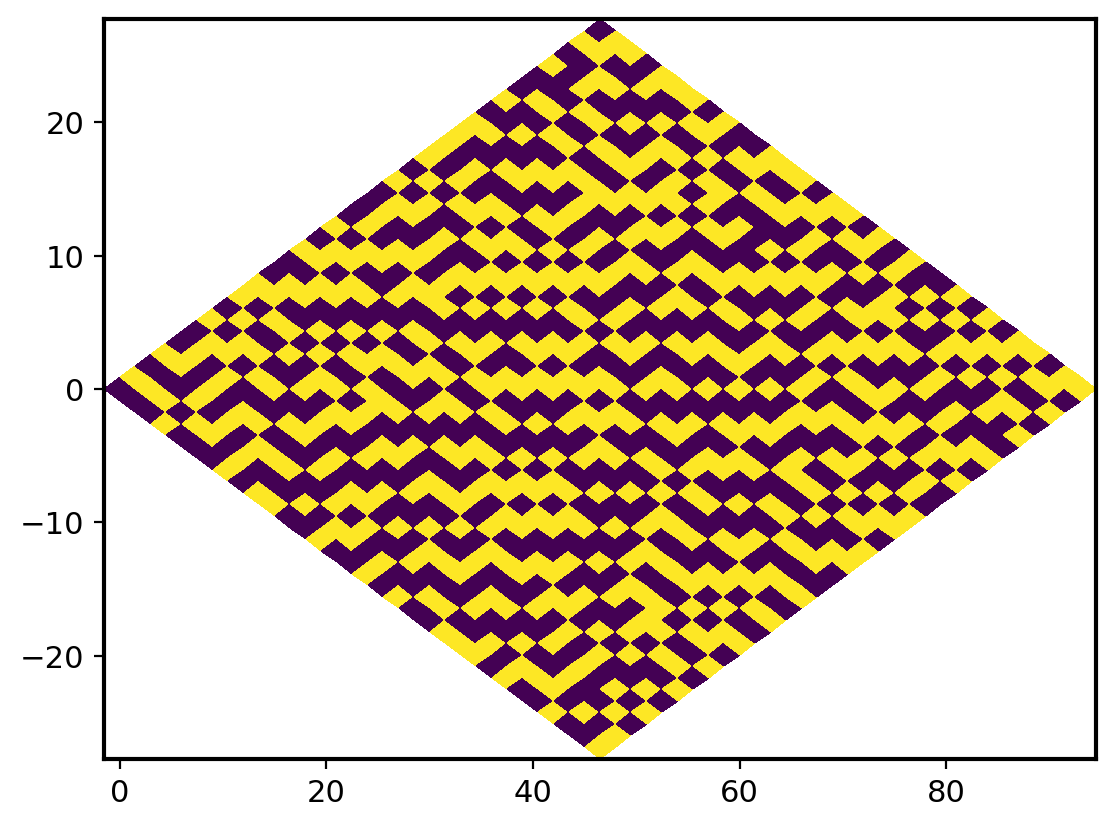

In [23]:
x,y = create_lattice(32)
plt.pcolormesh(x,y,init)

# Question 3

In [60]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
            E+= 0.25*J*init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
            E+= 0.25*J*init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
    return E

In [65]:
@nb.njit
def MCV_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    E  = np.zeros(Nsteps)
    E2  = np.zeros(Nsteps)
        
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            
            E0 += dE
            init[X,Y] *= -1
        E[k]  = E0/(N*N)
        E2[k] = E0*E0/(N*N)
        
    return E,E2

In [82]:
@nb.njit
def heat_capacity_vs_temperature(betas,Nsteps,warmup,init,J,B):
    size = len(init)
    Cv = np.zeros(len(betas))
    for i,b in enumerate(betas):
        E,E2 = MCV_step(Nsteps,b,init,J,B)
        Ed = np.average(E[warmup:])
        Cv[i] = b*b*(np.average(E2[warmup:]) - Ed*Ed*(size*size))
    return Cv

In [101]:
Nsteps = 10_000_000
betas = np.linspace(0,4,32)

init = spins_generator(8)
cv8 = heat_capacity_vs_temperature(betas,Nsteps,10_000,init,J=1,B=0)

init = spins_generator(16)
cv16 = heat_capacity_vs_temperature(betas,Nsteps,10_000,init,J=1,B=0)

init = spins_generator(32)
cv32 = heat_capacity_vs_temperature(betas,Nsteps,10_000,init,J=1,B=0)

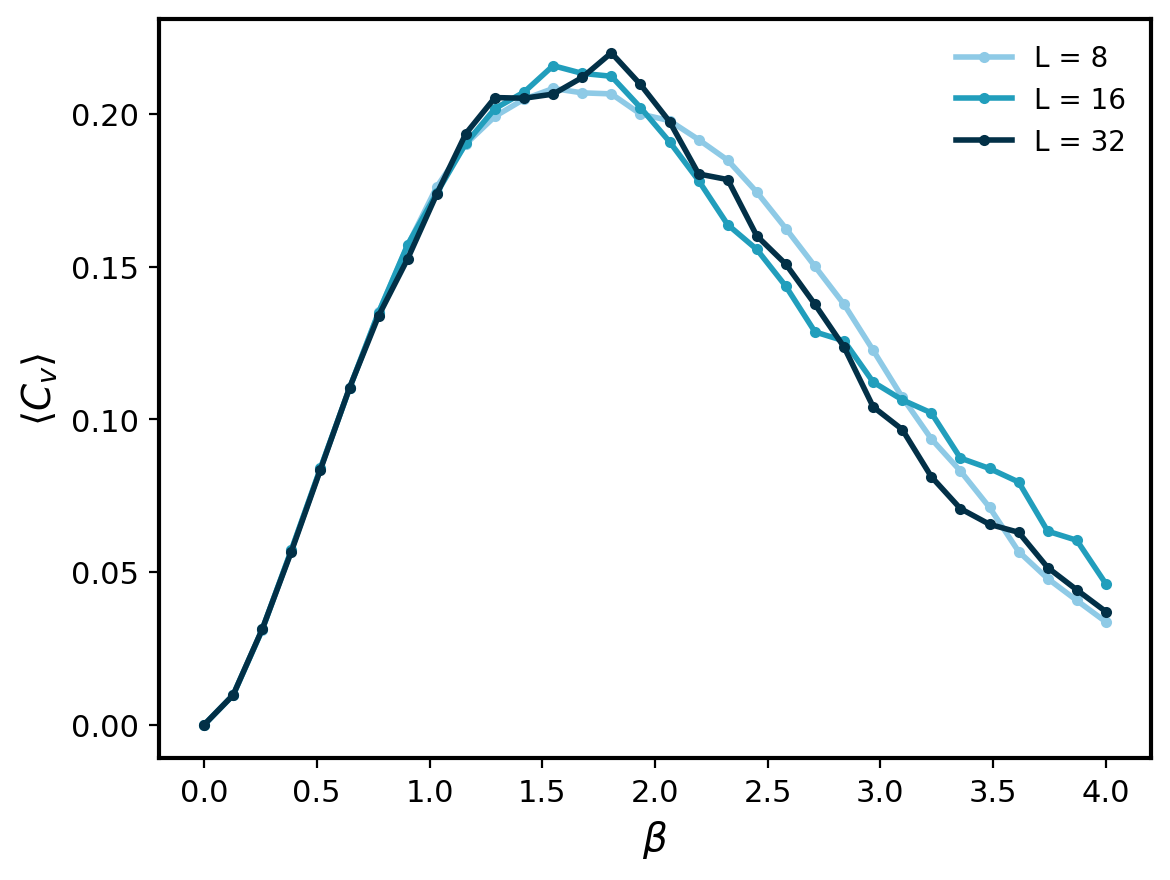

In [104]:
plt.plot(betas,cv8,".-",label="L = 8")
plt.plot(betas,cv16,".-",label="L = 16")
plt.plot(betas,cv32,".-",label="L = 32")

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\langle C_v \rangle $")
plt.legend(frameon=False)

In [105]:
Nsteps = 5_000_000
betas = np.linspace(0,1.0,32)

init = spins_generator(8)
cv8 = heat_capacity_vs_temperature(betas,Nsteps,10_000,init,J=1,B=0)

init = spins_generator(16)
cv16 = heat_capacity_vs_temperature(betas,Nsteps,10_000,init,J=1,B=0)

init = spins_generator(32)
cv32 = heat_capacity_vs_temperature(betas,Nsteps,10_000,init,J=1,B=0)

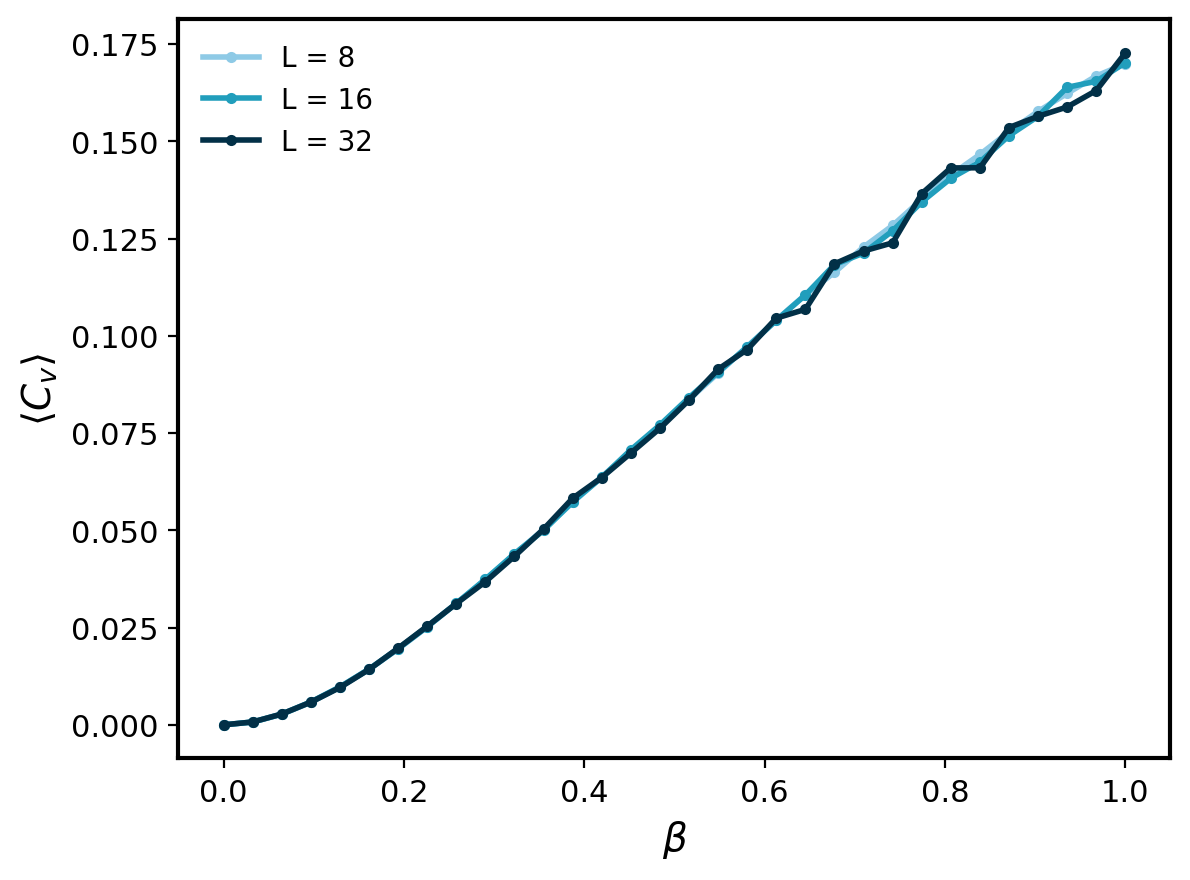

In [106]:
plt.plot(betas,cv8,".-",label="L = 8")
plt.plot(betas,cv16,".-",label="L = 16")
plt.plot(betas,cv32,".-",label="L = 32")

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\langle C_v \rangle $")
plt.legend(frameon=False)